# Approximations to the FPK equation

The notebook is related to Figure 4 in the paper and demonstrates different ways of solving the GP-SDE model. The methods considered are:
* Simulation by Euler-Maruyama
* Direct solution of the Fokker-Planck-Kolmogorov equation by finite differences
* Gaussian assumed density modelling (linearized)
* Gaussian assumed density modelling (moment matchng by symmetric 3rd order cubature)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.sparse import spdiags
from scipy.linalg import expm, cho_solve, cho_factor

import sys
sys.path.append("..")
from src.utility import get_observations, get_ellipsoid

## Helper functions and classes

In [2]:
class GP:
    def __init__(self, training_data, lengthscale, variance, noise_variance):
        self.X, self.Y     = training_data
        self.k_lengthscale = lengthscale
        self.k_variance    = variance
        self.variance      = noise_variance
        self.K = None
        self.K_inv = None
        
    def cov(self, x1, x2):
        k = np.linalg.norm(x1[:, None, :] - x2[None, :, :], axis=-1)**2
        k = -k/(2*self.k_lengthscale**2)
        k = np.exp(k)
        k = self.k_variance * k

        return k
    
    def _calc_K_inv(self):
        self.K = self.cov(self.X, self.X)
        temp = self.K + (self.variance * np.eye(self.X.shape[0]))
        self.K_inv = cho_solve(cho_factor(temp), np.eye(self.X.shape[0]))
    
    def predict_m(self, x):
        if self.K_inv is None:
            self._calc_K_inv()
        
        Kt = self.cov(x, self.X)
        
        Eft = Kt @ self.K_inv @ self.Y
        
        return Eft
        
        
    def predict_f(self, x):
        Ktt = self.cov(x,x)
        Kt  = self.cov(x, self.X)
        
        if self.K_inv is None:
            self._calc_K_inv()
        
        Vft = np.diag(Ktt - Kt @ self.K_inv @ Kt.T)
        Vft = Vft.reshape((x.shape[0], -1))
        
        return Vft
    
    def predict_y(self, x):
        Ktt = self.cov(x,x)
        Kt  = self.cov(x, self.X)
        
        if self.K_inv is None:
            self._calc_K_inv()
            
        Vft = np.diag(Ktt) - np.diag(Kt @ self.K_inv @ Kt.T) + self.variance
        Vft = Vft.reshape((x.shape[0], -1))
        
        return Vft
    
    def _du_covar(self, x, y):
        K =  self.cov(x,y)
        return -(x[:,0] - y[:,0].T)*K / self.k_variance **2

    def _dv_covar(self, x, y):
        K =  self.cov(x,y)
        return -(x[:,1] - y[:,1].T)*K / self.k_variance **2

    def get_jacobian(self, x):
        jacob1 = self._du_covar(x, self.X)
        jacob2 = self._dv_covar(x, self.X)
        
        yu = self.Y[:,0]
        yv = self.Y[:,1]
        
        if self.K_inv is None:
            self._calc_K_inv()
        
        t1 = np.concatenate((jacob1@(self.K_inv@yu), jacob2@(self.K_inv@yu)))
        t2 = np.concatenate((jacob1@(self.K_inv@yv), jacob2@(self.K_inv@yv)))

        t1 = t1.reshape((-1,1))
        t2 = t2.reshape((-1,1))
        t  = np.concatenate((t1, t2), axis=1)

        return t.T

In [3]:
def sigma_point_approx(x, xsi, w, gp_m):   
    m = x[:2].reshape((2, 1))
    s = x[2:].reshape((2, 2))
    L = np.linalg.cholesky(s)
    
    nxt_data = 0 * x
    
    projected_sigma_pnts = (np.repeat(m, xsi.shape[0], axis=1) + L @ xsi.T).T

    dm_dt = w.reshape((1, -1)) @ gp_m.predict_m(projected_sigma_pnts)
    dp_dt = np.zeros((2, 2))

    sde_f_vals = gp_m.predict_m(projected_sigma_pnts)

    for i, _e in enumerate(xsi):
        tmp = (
                sde_f_vals[i, :].reshape((2, 1))
                @ _e.reshape((2, 1)).T
                @ L.T
        )

        dp_dt += w[i].reshape(-1) * tmp

        tmp = (
            L
            @ _e.reshape((2, 1))
            @ (sde_f_vals[i, :].reshape((2, 1))).T
        )
        dp_dt += w[i].reshape(-1) * tmp

        tmp = np.eye(2) * gp_m.predict_y(projected_sigma_pnts[i].reshape((1, 2)))
        dp_dt += w[i].reshape(-1) * tmp

    nxt_data[:2] = dm_dt.reshape(-1)
    nxt_data[2:] = dp_dt.reshape(-1)

    return nxt_data


def linearize_approx(x, gp_model):
    m = x[0:2].reshape((1, 2))
    P = x[2:].reshape((2, 2))
    Fx = gp_model.get_jacobian(m)
    
    y = 0*x
    
    y[:2] = gp_model.predict_m(m)
    A = P @ Fx.T + Fx @ P + np.eye(2) * gp_model.predict_y(m)
    y[2:] = A.reshape(-1)
    
    return y

In [4]:
def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] + delta/2]

## Simulate observations

In [5]:
basename       = "bean"  # Options: "circle , bean"
n_observations = 8
noise_variance = 0.01
k_lengthscale  = 0.5
k_variance     = 0.5

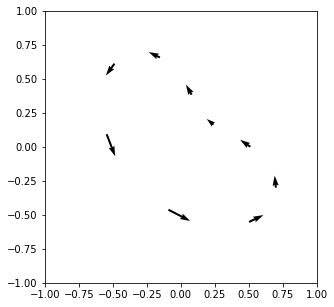

In [6]:
# Observations
u, v, yu, yv = get_observations(basename, n_observations)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect("equal", adjustable="box")

plt.quiver(u ,v, yu, yv)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

## GP Predicted Vector Field

In [7]:
x1 = np.linspace(-1,1,32)
x2 = np.linspace(-1,1,32)
xx, yy = np.meshgrid(x1, x2)
X = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))    

In [8]:
training_x = np.hstack((u.reshape(-1, 1), v.reshape(-1, 1)))
training_y = np.hstack((yu.reshape(-1, 1), yv.reshape(-1, 1)))

training_data = [training_x, training_y]

In [9]:
gp_model = GP(training_data, k_lengthscale, k_variance, noise_variance)

In [10]:
Eft = gp_model.predict_m(X)
Vft = gp_model.predict_f(X)

Eft_x = Eft[:,0].reshape((x1.shape[0], -1))
Eft_y = Eft[:,1].reshape((x1.shape[0], -1))
Vft = Vft.reshape((x1.shape[0], -1))

(-1, 1)

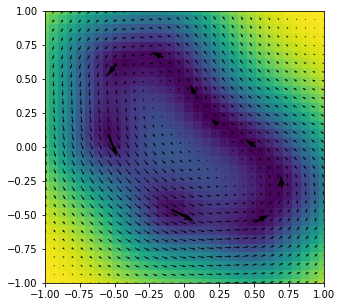

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect("equal", adjustable="box")

plt.imshow(np.sqrt(Vft), aspect='auto', interpolation='none',
           extent=extents(x1) + extents(x2), origin='lower')
plt.quiver(x1, x2, Eft_x, Eft_y)
plt.quiver(u , v, yu, yv)
plt.xlim(-1,1)
plt.ylim(-1,1)

## FPK operator by finite differences

In [12]:
L = 1
n = 64
q = 1

#  Form grid in Z
x_grid   = np.linspace(-L,L,n)
h        = x_grid[1] - x_grid[0]
[X1, X2] = np.meshgrid(x_grid,x_grid)
z        = np.concatenate((X2.reshape(-1,1), X1.reshape(-1, 1)), axis=1)

In [13]:
# Evaluate the GP for the grid points
Eft = gp_model.predict_m(z)
Vft = gp_model.predict_y(z)

Eft_x = Eft[:,0].reshape((-1, 1))
Eft_y = Eft[:,1].reshape((-1, 1))
Vft   = Vft.reshape((-1, 1))

f1  = Eft_x
f2  = Eft_y
Q11 = q*Vft
Q22 = q*Vft

In [14]:
#  Central differences
Fa =              Q11/2/h**2 + f1/(2*h)
Fb =  Q22/2/h**2             + f2/(2*h)
Fc = -Q22/h**2    -Q11/h**2  
Fd =  Q22/2/h**2             - f2/(2*h)
Fe =              Q22/2/h**2 - f1/(2*h)

F = spdiags(np.array([Fa, Fb, Fc, Fd, Fe]).reshape((5, -1)), np.array([-n, -1, 0, 1, n]), n**2, n**2)

In [15]:
# Time solution of the high-dimensional ODE by solvng the matrix exponential
# (this is the time-consuming operation)
dt    = 0.01
T_pde = expm((F*dt).todense())

In [16]:
x0 = np.array([-0.5, 0]).reshape((1, 2))
T  = np.linspace(0, 6, num=int(6//dt))

#  Initialize
pp      = np.zeros((n**2, 1))
ind     = np.argmin(np.linalg.norm(z[:, None, :] - x0[None, :, :], axis=-1))
pp[ind] = 1/h**2

pp_norm_data = np.zeros((T.shape[0], 64, 64))
for k in range(1, T.shape[0]):
    pp = T_pde @ pp

    pp_norm = np.divide(pp, np.sum(pp)/(h**2))
    pp_norm = pp_norm.reshape((n,n))
    
    pp_norm_data[k,:,:] = pp_norm.T


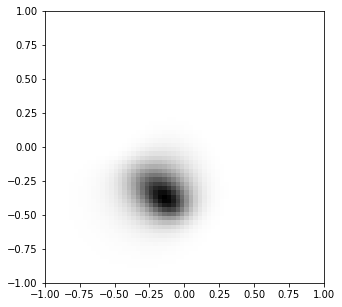

In [17]:
t = 0.5

idx = int(t//dt)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect("equal", adjustable="box")

plt.imshow(pp_norm_data[idx], aspect='auto', interpolation='none',
           extent=extents(x_grid) + extents(x_grid), origin='lower', cmap="gray_r")

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

## SDE using Euler-Maruyama

In [18]:
# Time
tspan = np.linspace(0, 6, 601)
dt    = tspan[1] - tspan[0]

# Number of particles
N = 1000

# Initial state
z0 = np.array([-0.5, 0]).reshape((1, 2))
z  = z0 + np.zeros((N, 2))

Z        = np.zeros((tspan.shape[0], N, 2))
Z[0,:,:] = z
n        = yu.shape[0]

mean_euler = np.zeros((tspan.shape[0], 2))
P_euler    = np.zeros((tspan.shape[0], 2, 2))

for i in range(1, tspan.shape[0]):
    # GP prediction 
    Eft = gp_model.predict_m(z)
    Vft = gp_model.predict_y(z)

    Eft_x = Eft[:,0].reshape((-1, 1))
    Eft_y = Eft[:,1].reshape((-1, 1))
    Vft   = Vft.reshape((-1, 1))
    
    # The drift
    F = np.concatenate((Eft_x, Eft_y), axis=1)
    L = np.concatenate((np.sqrt(Vft), np.sqrt(Vft)), axis=1)
    
    # Euler-Maruyama step
    Qc = 1;
    dt = tspan[i] - tspan[i-1]
    db = np.sqrt(dt*Qc) * np.random.randn(z.shape[0], z.shape[1])

    z = z + F*dt + np.multiply(L, db)

    Z[i,:,:] = z
    
    m = np.mean(z, axis=0)
    P = np.cov(z, rowvar=False)
    
    mean_euler[i, :] = m
    P_euler[i, :, :] = P
    

<Figure size 432x288 with 0 Axes>

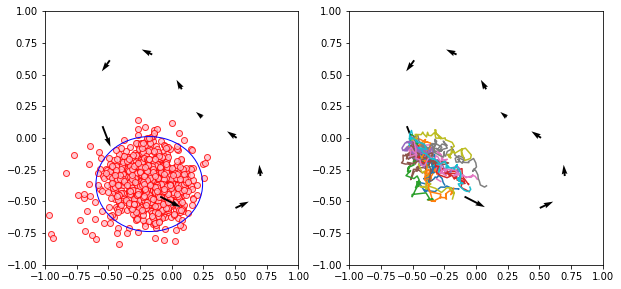

In [19]:
end_t = 0.5
euler_steps_idx = int(end_t//dt)

m_euler_i = mean_euler[euler_steps_idx, :]
p_euler_i = P_euler[euler_steps_idx, :, :]

mean_elip, major_axis, minor_axis, angle  = get_ellipsoid(m_euler_i, p_euler_i)
ellipse = Ellipse(
                    mean_elip,
                    width=major_axis,
                    height=minor_axis,
                    angle=angle,
                    facecolor="None",
                    edgecolor="blue",
                )

plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_aspect("equal", adjustable="box")
axs[1].set_aspect("equal", adjustable="box")

axs[0].scatter(Z[euler_steps_idx, :, 0].reshape((-1,1)), 
               Z[euler_steps_idx, :, 1].reshape((-1,1)), 
               c="pink", alpha=0.8, edgecolors="red")

axs[0].quiver(u , v, yu, yv)
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(-1, 1)

axs[0].add_patch(ellipse)

n_trajs = 20
random_trajs = np.random.randint(0, Z.shape[1], n_trajs)
for j in random_trajs:
    axs[1].plot(Z[:euler_steps_idx, j, 0], Z[:euler_steps_idx, j, 1])

axs[1].quiver(u , v, yu, yv)
axs[1].set_xlim(-1, 1)
axs[1].set_ylim(-1, 1)


plt.show()

## Linearization and Moment Matching

In [20]:
# Define the points and weights for the symmetric 3rd order cubature rule
d = 2;
xsi = np.sqrt(d) * np.concatenate((np.eye(d), -np.eye(d)), axis=1).T
w = (1/(2*d)) * np.ones((1,2*d))
w = w.reshape((-1, 1))

In [21]:
m0 = np.array([-0.5, 0]).reshape((1, 2))
P0 = 1e-6*np.eye(2)
x0 = np.concatenate((m0.reshape(-1), P0.reshape(-1)))

z    = x0
zlin = x0

data_sigma      = z
data_linearized = zlin

tspan = np.linspace(0, 6, 601)
dt    = tspan[1] - tspan[0]

for i in range(1, tspan.shape[0]):
    z    = z + sigma_point_approx(z, xsi, w, gp_model)*dt
    zlin = zlin + linearize_approx(zlin, gp_model)*dt
    
    data_sigma      = np.concatenate((data_sigma, z))
    data_linearized = np.concatenate((data_linearized, zlin))
    
data_sigma      = data_sigma.reshape((-1,6))
data_linearized = data_linearized.reshape((-1, 6))

<Figure size 432x288 with 0 Axes>

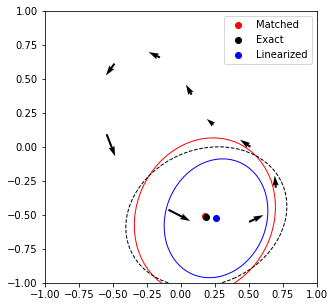

In [22]:
end_t = 1
euler_steps_idx = int(end_t//dt)

plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
#axs.scatter(m_sigma[0], m_sigma[1], c="red")
plt.quiver(u , v, yu, yv)
axs.set_xlim(-1, 1)
axs.set_ylim(-1, 1)

axs.set_aspect("equal", adjustable="box")

# Moment Matching
sigma_pnt_data = data_sigma[euler_steps_idx,:]
m_sigma = sigma_pnt_data[:2]
P_sigma = sigma_pnt_data[2:].reshape((2, 2))
axs.scatter(m_sigma[0], m_sigma[1], c="red", label='Matched')
mean_sigma, major_axis, minor_axis, angle  = get_ellipsoid(m_sigma, P_sigma)
e_sigma = Ellipse(
                    mean_sigma,
                    width=major_axis,
                    height=minor_axis,
                    angle=angle,
                    facecolor="None",
                    edgecolor="red",
                )
axs.add_patch(e_sigma)


# Euler Maruyama
m_euler_i = mean_euler[euler_steps_idx, :]
p_euler_i = P_euler[euler_steps_idx, :, :,]
axs.scatter(m_euler_i[0], m_euler_i[1], c="black", label='Exact')
mean_elip, major_axis, minor_axis, angle  = get_ellipsoid(m_euler_i, p_euler_i)
e_euler = Ellipse(
                    mean_elip,
                    linestyle="--",
                    width=major_axis,
                    height=minor_axis,
                    angle=angle,
                    facecolor="None",
                    edgecolor="black",
                )
axs.add_patch(e_euler)

# Linearized
lin_pnt_data = data_linearized[euler_steps_idx,:]
m_lin= lin_pnt_data[:2]
P_lin = lin_pnt_data[2:].reshape((2, 2))
mean_lin, major_axis, minor_axis, angle = get_ellipsoid(m_lin, P_lin)
axs.scatter(m_lin[0], m_lin[1], c="blue", label='Linearized')
e_lin = Ellipse(
                    mean_lin,
                    width=major_axis,
                    height=minor_axis,
                    angle=angle,
                    facecolor="None",
                    edgecolor="blue",
                )
axs.add_patch(e_lin)
axs.legend()

plt.show()